# Create Project

In [6]:
#import basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load the Data

In [3]:
#create pandas dataframe
filename='Data/sales_predictions - sales_predictions (1).csv'
df = pd.read_csv(filename)


## Initial Data Inspection

In [4]:
#look at column ypes and datagrame head
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [8]:
# check for rows and columns
df.shape


(8523, 12)

- There are 12 columns and 8,523 rows
- There is missing data in Item Weight and Outlet Size. 

# Initial Data Preparation and Cleaning

## Duplicated Values

In [11]:
# check for duplicates
df.duplicated().sum()

0

- There are no duplicated values. 

## Missing Values

In [13]:
#identify missing data
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [14]:
# there is missing data in "Item_weight" and "Outlet Size
# for exploratory visualization drop all missing values
df.dropna(inplace = True)


In [15]:
#double check dropped rows
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Check All Columns

- This are  many data issues with object columns.
 - Item Identifier, Item Visibility  and Item Weight have no obvious issues

In [19]:
#check the syntax and spelling errors
df['Item_Fat_Content'].value_counts()

Low Fat    2774
Regular    1575
LF          177
reg          71
low fat      53
Name: Item_Fat_Content, dtype: int64

- Spelling inconsistencies need to be addressed. 

In [21]:
# fix the inconsistencies
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')
#check the column
df['Item_Fat_Content'].value_counts()

Low Fat    3004
Regular    1646
Name: Item_Fat_Content, dtype: int64

In [24]:
# check Item type
df['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Household', 'Baking Goods',
       'Snack Foods', 'Fruits and Vegetables', 'Breakfast',
       'Health and Hygiene', 'Frozen Foods', 'Hard Drinks', 'Canned',
       'Starchy Foods', 'Breads', 'Others', 'Seafood'], dtype=object)

In [25]:
# check outlet type
df['Outlet_Type'].unique()

array(['Supermarket Type1', 'Supermarket Type2'], dtype=object)

In [27]:
# check outlet type
df['Outlet_Location_Type'].unique()

array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object)

In [28]:
#check the syntax and spelling errors
df['Outlet_Size'].value_counts()

Small     1860
Medium    1858
High       932
Name: Outlet_Size, dtype: int64

- All inconsistencies are addressed in object columns. 

# Preliminary Visuals

##  Functions for visuals

In [29]:
# function for numeric values
def plot_numeric(df,col):
  ## make the figure and axes sharing the same x-axis
  fig, axes = plt.subplots(nrows=2, figsize=(10,5), sharex=True)

  ## Use seaborn plots with ax=axes[i]
  sns.histplot(data=df,x = col,ax = axes[0])
  mean_value = df[col].mean()
  axes[0].axvline(mean_value,color='red', ls='--', 
           label=f"Mean Value = ${mean_value:,.2f}",);

  med_value = df[col].median()
  axes[0].axvline(med_value,color='black', ls='--', 
           label=f"Median Value = ${med_value:,.2f}");


  sns.boxplot(data=df, x = col, ax = axes[1])

  ## Updating title of top graph 
  axes[0].set_title(f'EDA for {col}')

  ## Fixing any overlapping labels and showing
  plt.tight_layout()
  plt.show()

## Exploratory Visuals

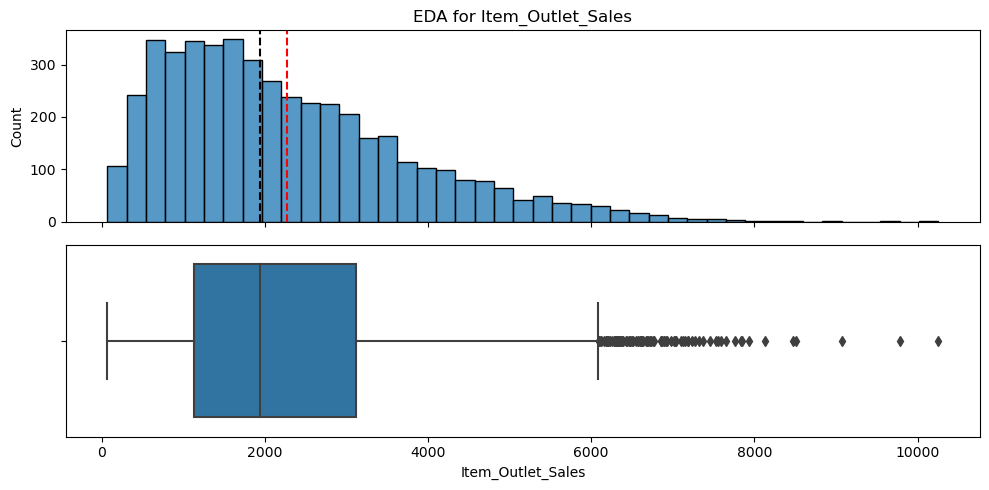

In [30]:
plot_numeric(df,'Item_Outlet_Sales')

- There are  outliers in the 8,000+ sales. 

C:\Users\Elizabeth Spreng\AppData\Local\Temp\ipykernel_25796\4116594592.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True,cmap='PuOr');


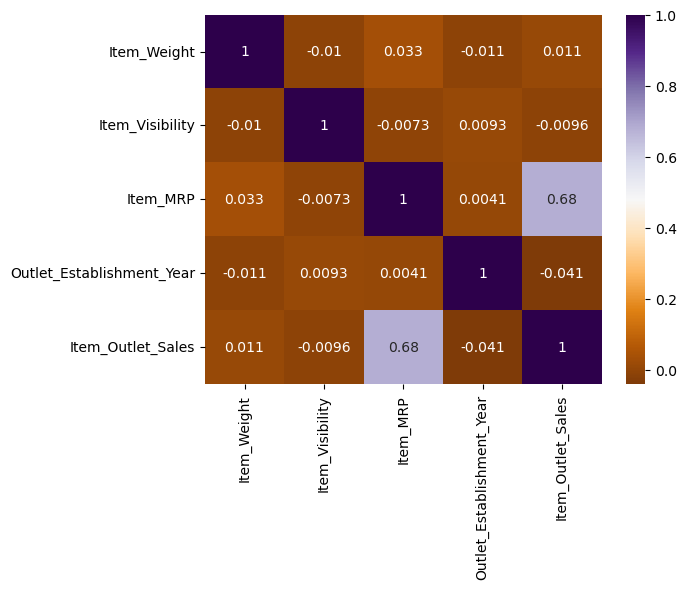

In [48]:
# look at heat map
pd.options.mode.chained_assignment = None

sns.heatmap(df.corr(),annot=True,cmap='PuOr');


In [35]:
# look at heat map
num_columns=df['Item_Weight','Item_Visibility']
# look at heat map
#ns.heatmap(df.corr(),annot=True,cmap='Blues');


KeyError: ('Item_Weight', 'Item_Visibility')